In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from functools import partial
from tqdm import tqdm

In [2]:
models = ["bert_uncased", "multiqa_mpnet_dot", "mpnet", "tfidf", "fasttext_facilex"]
df_all = []
path = "./data/caselaw_emb"

# load in the individual jurisdictions and combine them into one dataframe
for jurisdiction in os.listdir(path):
    aux = pd.read_pickle(f"{path}/{jurisdiction}/emb_{models[0]}.pickle")
    for model in models[:]:
        read_df = pd.read_pickle(f"./data/caselaw_emb/{jurisdiction}/emb_{model}.pickle")
        if type(read_df) == pd.DataFrame:
            aux[read_df.columns[-1]] = read_df[read_df.columns[-1]]
        else:
            model = "embedding_" + model
            aux[model] = list(read_df)

    df_all.append(aux)

df_all = pd.concat(df_all)
df_all = df_all.reset_index(drop = True)
print(df_all.shape)
df_all.head()

(317, 31)


,title,court,courtEng,dateOfDocument,jurisdiction,keywords,summary,summaryEn,language,decisionType,...,text,classifiers,celex,citation_all,citation_article,embedding_bert-base-uncased,embedding_multi-qa-mpnet-base-dot-v1,embedding_all-mpnet-base-v2,embedding_tfidf,embedding_fasttext_facilex
0,"Rechtbank Amsterdam, 11-06-2020, ECLI:NL:RBAMS...",Rechtbank Amsterdam,Court of Amsterdam,2020-11-10T23:00:00Z,Netherlands,"[FW Decision 2002/584 (EAW), assault]",None,The case concerns the crime of [assault.] prov...,"{'label': 'Dutch', 'code': 'NL'}","{'label': 'Judgment', 'code': 'J'}",...,,[Non-mandatory ground for refusal (double crim...,{32002F0584},"{32002F0584.Article_3.Paragraph_3, 32002F0584....","{32002F0584.Article_2, 32002F0584.Article_3}","[-0.462717, 0.06187152, 0.03336446, -0.3502581...","[0.36602938, -0.13564043, -0.08998994, -0.0305...","[0.07333616, -0.055307057, 0.046860103, 0.0131...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.03847168, -0.025246186, 0.027346246, -0.005..."
1,"Rechtbank Amsterdam, 14-09-2023, ECLI:NL:RBAMS...",Rechtbank Amsterdam,Court of Amsterdam,2023-09-13T22:00:00Z,Netherlands,"[Regulation 2018/1805, crime unknown]",,The case concerns the crime of [unknown] provi...,"{'label': 'Dutch', 'code': 'NL'}","{'label': 'Judgment', 'code': 'J'}",...,,"[Freezing, Transmission of a freezing/confisca...",{32018R1805},"{32018R1805.Article_4.Paragraph_1, 32018R1805....","{32018R1805.Article_8, 32018R1805.Article_4}","[-0.31860715, 0.106375396, 0.07862492, -0.2776...","[0.31108513, 0.007556932, -0.02016174, 0.40182...","[0.054476235, 0.041393988, 0.012051634, 0.0693...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.067469604, 0.02719136, -0.0075165145, 0.018..."
2,"Rechtbank Noord-Nederland, 13-12-2023, ECLI:NL...",Rechtbank Noord-Nederland,Court of northern Netherlands,2023-12-12T23:00:00Z,Netherlands,"[Regulation 2018/1805, drug cultivation]",,The case concerns thecrime of [drug cultivatio...,"{'label': 'Dutch', 'code': 'NL'}","{'label': 'Judgment', 'code': 'J'}",...,,"[Confiscation, Grounds for non-recognition/non...",{32018R1805},"{32018R1805.Article_19.Paragraph_1.Letter_h, 3...",{32018R1805.Article_19},"[-0.32747883, 0.077745266, -0.005084518, -0.23...","[0.15722609, -0.01780169, 0.00019851288, 0.211...","[0.032698214, 0.006227661, 0.04437305, 0.04650...","[0.03484054219702668, 0.0, 0.0, 0.0, 0.0, 0.04...","[0.03978737, 0.0077718156, 0.037166152, 0.0367..."
3,"Rechtbank Amsterdam, 10-02-2022, ECLI:NL:RBAMS...",Rechtbank Amsterdam,Court of Amsterdam,2022-02-09T23:00:00Z,Netherlands,"[FW Decision 2002/584 (EAW), driving a motor v...",,The case concerns the crime of [driving a moto...,"{'label': 'Dutch', 'code': 'NL'}","{'label': 'Judgment', 'code': 'J'}",...,,[Non-mandatory ground for refusal (double crim...,{32002F0584},"{32002F0584.Article_13, 32002F0584.Article_2.P...","{32002F0584.Article_2, 32002F0584.Article_13}","[-0.42744553, 0.018157233, 0.06460364, -0.2898...","[0.09991563, -0.18537301, -0.08078547, 0.14107...","[0.034546424, -0.02873704, 0.04117731, 0.00520...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.061911363, -0.027440717, 0.021913657, 0.013..."
4,"Rechtbank Amsterdam, 03-08-2023, ECLI:NL:RBAMS...",Rechtbank Amsterdam,Court of Amsterdam,2023-08-02T22:00:00Z,Netherlands,"[FW Decision 2002/584 (EAW), attempted theft i...",,The case concerns the crime of [attempted thef...,"{'label': 'Dutch', 'code': 'NL'}","{'label': 'Judgment', 'code': 'J'}",...,,[Non-mandatory ground for refusal (double crim...,{32002F0584},"{32002F0584.Article_4a.Paragraph_1, 32002F0584...","{32002F0584.Article_2, 32002F0584.Article_4a, ...","[-0.424509, -0.01849142, 0.017533816, -0.34515...","[0.24081075, -0.2647753, -0.11420538, 0.194631...","[0.06733398, -0.04646661, 0.031646624, 0.01614...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.045386843, -0.026883297, 0.01750043, -0.000..."


$P=\frac{relevant\ retrieved\ docs}{total\ retrieved\ docs}$

$R=\frac{relevant\ retrieved\ docs}{total\ retrieved\ docs\ in\ dataset}$

$MRR=\frac{1}{|Q|}\sum_q^Q \frac{1}{rank_q}$

$rank_q = 0$ if there are no relevant documents in the retrieved search window\

In [34]:
from IPython.display import display, Latex

# used for ease of reading
# https://stackoverflow.com/questions/39473297/how-do-i-print-colored-output-with-python-3
class color_printing():
    END = "\x1b[0m"
    Italic = "\x1b[3m"
    # If Foreground is False that means color effect on Background

    def RGB(R, G, B, Foreground = True): # R: 0-255  ,  G: 0-255  ,  B: 0-255
        FB_G = 38 # Effect on foreground
        if Foreground != True:
            FB_G = 48 # Effect on background
        return "\x1b[" + str(FB_G) + ";2;" + str(R) + ";" + str(G) + ";" + str(B) + "m"
    
    def print_string(text, colours):
        return color_printing.RGB(*colours) + text + color_printing.END

def evaluate(retrieval_scores, missed_retrieval_scores, top_k):
    metrics = {}

    #### precision 
    metrics[f"precision@{top_k}"] = round(np.mean(np.sum(retrieval_scores, axis = 1)/top_k, 0), 3)

    #### mean average precision for a retrieval window of k = 5
    average_precision = np.sum([(np.sum(retrieval_scores[:, :k], axis = 1)/k) * retrieval_scores[:, k-1] for k in range(1, top_k+1)])/top_k
    metrics[f"map@{top_k}"] = round(average_precision/len(retrieval_scores), 3)
    
    #### MRR and MRR missed
    aux_retrieval_scores = np.hstack([np.zeros((retrieval_scores.shape[0], 1)), retrieval_scores])
    rank = np.argmax(aux_retrieval_scores, axis = 1) # get first non-zero rank
    missed = np.min([top_k - np.count_nonzero(retrieval_scores, axis = 1), np.sum(missed_retrieval_scores, axis = 1)], axis = 0)
    running_mrr = np.sum(np.divide(1, rank, where = rank != 0)) # rank starts at 0 bcs. of this so rank + 1
    running_mrr_miss = np.sum(np.divide(1, rank + missed, where = rank != 0)) # rank starts at 0 bcs. of this so rank + 1
    metrics[f"mrr@{top_k}"] = round(running_mrr/(len(retrieval_scores)), 3)
    metrics[f"mrr_miss@{top_k}"] = round(running_mrr_miss/len(retrieval_scores), 3)

    #### hitrate
    metrics[f"hitrate@{top_k}"] = round(np.sum(np.any(retrieval_scores, axis = 1))/len(retrieval_scores), 3)

    # display of formula computations to facilitate understanding
    #### precision
    running_precision_latex = [r"\frac{%d}{%d}" % (np.sum(retrieved), top_k) for retrieved in retrieval_scores]
    display(Latex("Precision@%d $= \\frac{\\#\\text{relevant retrieved cases}}{\\#\\text{total retrieved cases}} = " % (top_k) + "\\frac{{1}}{%d}\cdot(%s)" % (len(running_precision_latex), '+'.join(running_precision_latex)) + f"={metrics[f'precision@{top_k}']}$"))

    #### MRR
    sum_mrr_latex = [r'\frac{%d}{%d}' % (1, np.argmax(np.hstack([[0], retrieved]))) for retrieved in retrieval_scores]
    running_mrr_latex = "\\frac{{1}}{%d}\cdot(%s)" % (retrieval_scores.shape[0], '+'.join(sum_mrr_latex))
    display(Latex("MRR@%d $= \\frac{1}{\\text{\\# queries}}\\sum_q^Q \\frac{1}{rank_q}=" % (top_k) + running_mrr_latex + f"= {metrics[f'mrr@{top_k}']}$"))
    
    ### MRR miss
    sum_mrr_miss_latex = [r'\frac{%d}{%d+%d}' % (1, np.argmax(np.hstack([[0], retrieved])), np.min([top_k - np.count_nonzero(retrieved), np.sum(missed)])) for retrieved, missed in zip(retrieval_scores, missed_retrieval_scores)]
    running_mrr_miss_latex = "\\frac{{1}}{%d}\cdot(%s)" % (retrieval_scores.shape[0], '+'.join(sum_mrr_miss_latex))
    display(Latex("MRR missed@%d $= \\frac{1}{\\text{\\# queries}}\\sum_q^Q \\frac{1}{rank_q+miss_q}=" % (top_k) + running_mrr_miss_latex + f"= {metrics[f'mrr_miss@{top_k}']}$"))

    ### hitrate
    running_hitrate_latex = ["%d" % (np.any(retrieved)) for retrieved in retrieval_scores]
    display(Latex("Hitrate@%d $=\\frac{1}{\\text{\\# queries}}\\sum_q^Q any\\_rel(q)=" % (top_k) + "\\frac{{1}}{%d}\cdot (%s)" % (len(retrieval_scores), '+'.join(running_hitrate_latex)) + f" = {metrics[f'hitrate@{top_k}']}$"))

    ### average precision
    running_ap_latex = ["[" + "+".join(['\\frac{%d}{%d}\cdot%d' % (np.sum(retrieved[:k]), k, retrieved[k-1]) for k in range(1, top_k+1)]) + "]" for retrieved in retrieval_scores]
    running_ap_latex_aux_calculations = np.round([[np.sum(retrieved[:k])/k*retrieved[k-1] for k in range(1, top_k+1)] for retrieved in retrieval_scores], 3)
    display(Latex("MAP@%d $ = \\frac{1}{\\text{\\# queries}}\\sum_q^Q \\frac{1}{\\text{top\\_k}}\sum_{k=1}^{\\text{top\\_k}}P_q(k)\\cdot rel_q(k)=" % (top_k) + "\\frac{{1}}{%d}(%s)" % (len(retrieval_scores), '+'.join(running_ap_latex)) + "= \\frac{{1}}{%d}" % (len(retrieval_scores))+ f"({'+'.join(np.sum(running_ap_latex_aux_calculations, axis = 1).astype(str))}) = {metrics[f'map@{top_k}']}$"))

    return metrics

def unit_test(sample_case, search_corpus, query_type, top_k, model):
    # name mapping to disambiguate what the system used as the ground truth
    query_map = {
        "celex": "CELEX ID",
        "citation_article": "article-only EU citation"
    }

    if len(sample_case) < 2:
        cosine_scores = cosine_similarity(np.asarray(sample_case[model].tolist()).reshape(1,-1), np.asarray(search_corpus[model].tolist()))
    else:
        cosine_scores = cosine_similarity(np.asarray(sample_case[model].tolist()), np.asarray(search_corpus[model].tolist()))

    retrieval_scores = []
    missed_retrieval_scores = []

    for idx in range(sample_case.shape[0]):
        all_matches = np.argsort(cosine_scores[idx])[::-1]

        best_matches = all_matches[1:top_k+1]
        query_celex = sample_case.iloc[idx][query_type]

        print(f"CELEX ID of query case = {color_printing.print_string(str(query_celex), colours = (255, 150, 0))}")
        print("---------------")

        # see which top_k retrieved documents were retrieved
        score = []
        for retrieved_case in best_matches:
            retrieved_celex = search_corpus.iloc[retrieved_case][query_type]
            score.append(int(len(query_celex & retrieved_celex) > 0))

            print(f"CELEX IDs of retrieved case = {color_printing.print_string(str(retrieved_celex), colours = (255, 150, 0))} | They share at least one {color_printing.print_string(query_map[query_type], colours = (0, 150, 0))} = {color_printing.print_string(str(len(retrieved_celex & query_celex) > 0), colours = (255, 150, 0))} ===>> Retrieval score becomes = {color_printing.print_string(str(score), colours = (255, 150, 0))}")

        ### find all relevant cases that were missed
        missed_matches = []
        # for retrieved_case in all_matches[1:len(df_temp)]:
        for retrieved_case in all_matches[1:]:
            retrieved_celex = search_corpus.iloc[retrieved_case][query_type]
            missed_matches.append(int(len(query_celex & retrieved_celex) > 0))

        print("=====================")
        print(f"Final retrieval score = {color_printing.print_string(str(score), colours = (255, 150, 0))} ==>> There are {color_printing.print_string(str(np.sum(score)), colours = (255, 150, 0))} retrieved cases which share the same {color_printing.print_string(query_map[query_type], colours = (0, 150, 0))} as the query case, out of k = {color_printing.print_string(str(top_k), colours = (255, 150, 0))}")
        print(f"Number of cases relevant to the query, which are present in the entire dataset but not in the retrieval window = {color_printing.print_string(str(np.sum(missed_matches)), colours = (255, 150, 0))}; however, there are {color_printing.print_string(str(top_k - np.count_nonzero(score)), colours = (255, 150, 0))} retrieved non-relevant cases")

        score = np.asarray(score)
        missed_matches = np.asarray(missed_matches)
        retrieval_scores.append(score)
        missed_retrieval_scores.append(missed_matches)

    metrics = evaluate(np.asarray(retrieval_scores), np.asarray(missed_retrieval_scores), top_k = 5)
        
    return metrics

unit_test(df_all.iloc[7:10], df_all, "citation_article", 5, model = "embedding_multi-qa-mpnet-base-dot-v1")

CELEX ID of query case = {'32018R1805.Article_8', '32018R1805.Article_4'}
---------------
CELEX IDs of retrieved case = {'32018R1805.Article_8'} | They share at least one article-only EU citation = True ===>> Retrieval score becomes = [1]
CELEX IDs of retrieved case = {'32018R1805.Article_8'} | They share at least one article-only EU citation = True ===>> Retrieval score becomes = [1, 1]
CELEX IDs of retrieved case = {'32018R1805.Article_8', '32018R1805.Article_4'} | They share at least one article-only EU citation = True ===>> Retrieval score becomes = [1, 1, 1]
CELEX IDs of retrieved case = {'32018R1805.Article_8', '32018R1805.Article_4'} | They share at least one article-only EU citation = True ===>> Retrieval score becomes = [1, 1, 1, 1]
CELEX IDs of retrieved case = {'32018R1805.Article_19'} | They share at least one article-only EU citation = False ===>> Retrieval score becomes = [1, 1, 1, 1, 0]
Final retrieval score = [1, 1, 1, 1, 0] ==>> There are 4 retrieved cases which share 

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

{'precision@5': 0.8,
 'map@5': 0.787,
 'mrr@5': 1.0,
 'mrr_miss@5': 0.5,
 'hitrate@5': 1.0}

In [27]:
def write_output(df_entry, file, **additional_information):
    if additional_information["output_type"] == "query":
        file.write(f"\n===================\n")
        file.write(f"({df_entry['jurisdiction']}) ({df_entry['celex']}) ({df_entry['title']})\n")
        file.write(df_entry["summaryEn"])
        file.write(f"\n===================\nRetrieved cases (top {additional_information['top_k']})\n------------\n")
    else:
        file.write(f"({df_entry['celex'] & additional_information['df_entry_retrieved']['retrieved_celex']}) ({additional_information['df_entry_retrieved']['jurisdiction']}) ({additional_information['df_entry_retrieved']['title']})\n")
        file.write(additional_information['df_entry_retrieved']["summaryEn"])
        file.write("\n\n")

def evaluate(retrieval_scores, missed_retrieval_scores, top_k):
    metrics = {}

    #### precision 
    metrics[f"precision@{top_k}"] = round(np.mean(np.sum(retrieval_scores, axis = 1)/top_k, 0), 3)

    #### map@5
    average_precision = np.sum([(np.sum(retrieval_scores[:, :k], axis = 1)/k) * retrieval_scores[:, k-1] for k in range(1, top_k+1)])/top_k
    metrics[f"map@{top_k}"] = round(average_precision/len(retrieval_scores), 3)
    
    #### MRR
    aux_retrieval_scores = np.hstack([np.zeros((retrieval_scores.shape[0], 1)), retrieval_scores])
    rank = np.argmax(aux_retrieval_scores, axis = 1) # get first non-zero rank
    running_mrr = np.sum(np.divide(1, rank, where = rank != 0)) # rank starts at 0 bcs. of this so rank + 1
    metrics[f"mrr@{top_k}"] = round(running_mrr/(len(retrieval_scores)), 3)

    return metrics

# def pr_curve(retrieval_scores, missed_retrieval_scores):
#     aux = []
#     for k in range(1,5+1):
#         precision = np.mean(np.sum(retrieval_scores[:k], axis = 1)/k, 0)
#         recall = np.mean(np.sum(retrieval_scores[:,:k], axis = 1)/np.sum(missed_retrieval_scores[:,:k], axis=1))
#         aux.append([precision, recall])
#     print(aux)

def cosine_search_output(query, search, query_type, df, top_k = 5, debug_output: int = 0):
    if debug_output:
        texts = open(f"output_combined.txt", "w")
    
    cosine_scores = cosine_similarity(query, search)
    retrieval_scores = []
    missed_retrieval_scores = []
    
    for i in range(cosine_scores.shape[0]):
        all_matches = np.argsort(cosine_scores[i])[::-1]

        best_matches = all_matches[1:top_k+1]
        query_celex = df.iloc[i][query_type]

        write_output(df.iloc[0], texts, top_k = top_k) if i < debug_output else 1

        # see which top_k retrieved documents were retrieved
        score = []
        for retrieved_case in best_matches:
            retrieved_celex = df.iloc[retrieved_case][query_type]
            score.append(int(len(query_celex & retrieved_celex) > 0))
            write_output(df.iloc[i], texts, top_k = top_k, df_entry_retrieved = df.iloc[retrieved_case]) if i < debug_output else 1

        ### find all relevant cases that were missed
        missed_matches = []
        # for retrieved_case in all_matches[1:]:
        for retrieved_case in all_matches[top_k+1:]:
            retrieved_celex = df.iloc[retrieved_case][query_type]
            missed_matches.append(int(len(query_celex & retrieved_celex) > 0))

        score = np.asarray(score)
        retrieval_scores.append(score)
        missed_retrieval_scores.append(missed_matches)
        
    texts.close() if debug_output else 1

    return np.asarray(retrieval_scores), np.asarray(missed_retrieval_scores)

In [26]:
search_functions = [partial(cosine_search_output, query_type = "celex"), partial(cosine_search_output, query_type = "citation_article")]

scores_search_function = defaultdict()

metrics = {"Model": [], "Value": [], "Score": [], "Query_type": []}
for idx, search_func in enumerate(search_functions):
    aux = df_all.copy()
    subset = aux
    for model in tqdm(df_all.columns):
        if "embedding" not in model:
            continue
        embds_query = np.asarray(subset[model].tolist())
        embds_corpus = np.asarray(df_all[model].tolist())

        retrieval_scores, missed_retrieval_scores = search_func(query = embds_query, search = embds_corpus, df = df_all, top_k = 5)
        evaluation_results = evaluate(retrieval_scores, missed_retrieval_scores, top_k = 5)
        metrics["Model"] += ["_".join(model.split("_")[1:])] * len(list(evaluation_results.keys()))
        metrics["Value"] += list(evaluation_results.values())
        metrics["Score"] += list(evaluation_results.keys())

    metrics["Query_type"] += [list(search_func.keywords.values())[0]] * (len(metrics["Model"])//(idx+1))
metrics = pd.DataFrame(metrics)

 87%|████████▋ | 27/31 [00:01<00:00, 20.83it/s]

embedding_bert-base-uncased
embedding_multi-qa-mpnet-base-dot-v1
embedding_all-mpnet-base-v2


 97%|█████████▋| 30/31 [00:05<00:00,  4.50it/s]

embedding_tfidf


100%|██████████| 31/31 [00:06<00:00,  4.75it/s]


embedding_fasttext_facilex


 87%|████████▋ | 27/31 [00:01<00:00, 21.25it/s]

embedding_bert-base-uncased
embedding_multi-qa-mpnet-base-dot-v1
embedding_all-mpnet-base-v2


 97%|█████████▋| 30/31 [00:05<00:00,  4.32it/s]

embedding_tfidf


100%|██████████| 31/31 [00:06<00:00,  4.63it/s]

embedding_fasttext_facilex


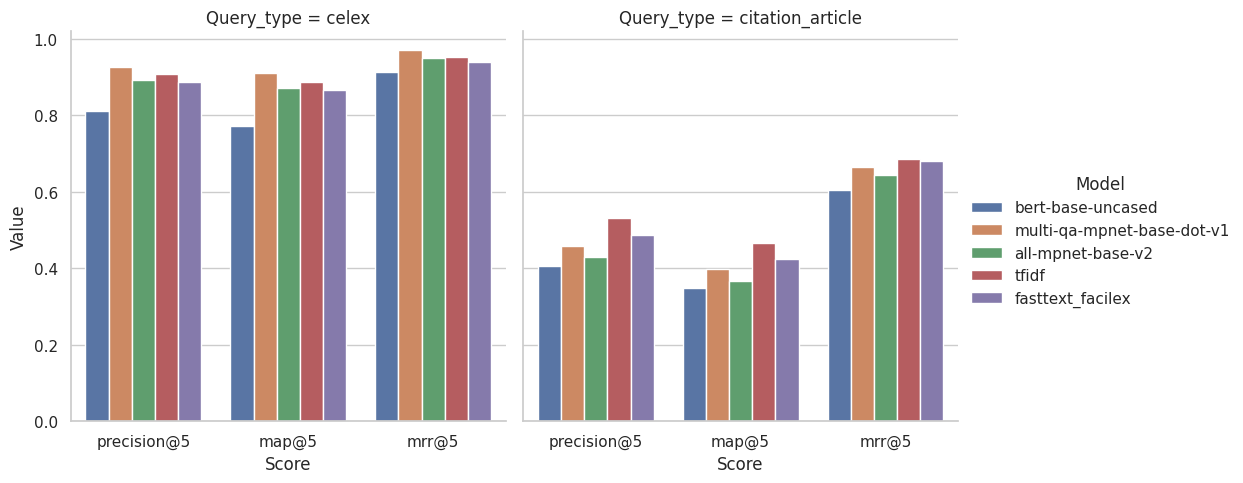

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = "whitegrid")
fig = sns.catplot(kind = "bar", data = metrics, x = "Score", y = "Value", col = "Query_type", hue = "Model")

plt.show()